In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.base import clone
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import cProfile
import pstats
import io
import time

In [ ]:
file_path = 'soybean.csv'
data = pd.read_csv(file_path)

In [ ]:
X = data.drop(columns=['yield',  'year', 'loc_ID'])
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
print(numerical_features)
y = data['yield'].values
X.shape

Index(['W_1_1', 'W_1_2', 'W_1_3', 'W_1_4', 'W_1_5', 'W_1_6', 'W_1_7', 'W_1_8',
       'W_1_9', 'W_1_10',
       ...
       'P_5', 'P_6', 'P_7', 'P_8', 'P_9', 'P_10', 'P_11', 'P_12', 'P_13',
       'P_14'],
      dtype='object', length=392)


(25345, 392)

In [ ]:
from dataclasses import dataclass





# Function to detect and remove outliers using IQR
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.005)  # Lower percentile (0.5%)
        Q3 = df[feature].quantile(0.995)  # Upper percentile (99.5%)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df


# Remove outliers from numerical features
X = remove_outliers_iqr(X, numerical_features)
print(X.shape)
# Ensure the target variable is aligned with the filtered features
y = y[X.index]

# Pre-processing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])



# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),

    ])

# Dimensionality Reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% of variance

# Full pipeline with preprocessing and PCA
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)  # Comment this line out if PCA is not needed
])

# Apply the pipeline to the data
X = model_pipeline.fit_transform(X)

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X_processed, y_no_outliers, test_size=0.2, random_state=42)

print("Pre-processing completed successfully!")


(24744, 392)
Pre-processing completed successfully!


In [ ]:
X.shape

(24744, 117)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Assume we start with 10 initial labeled examples
initial_labeled_indices = list(np.random.choice(len(X_train), 500, replace=False))



In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, R2: {r2:.4f}')


MSE: 39.2783, R2: 0.6721


In [ ]:
model = LinearRegression()
model.fit(X_train[initial_labeled_indices],y_train[initial_labeled_indices])
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, R2: {r2:.4f}')


MSE: 54.5301, R2: 0.5448


In [ ]:
def plot_metrics(mse_list, r2_list):
    iterations = list(range(1, len(mse_list) + 1))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(iterations, mse_list, marker='o', label='MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('MSE over Iterations')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iterations, r2_list, marker='o', label='R²', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('R²')
    plt.title('R² over Iterations')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
class RandomSampling:
    def __init__(self, X, y, model='linear'):
        self.X = X
        self.y = y
        self.model_type = model


    def train_model(self, X, y):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'gbdt':
            model = GradientBoostingRegressor()
        elif self.model_type == 'rf':
            model = RandomForestRegressor()
        elif self.model_type == 'svm':
            model = SVR(kernel='rbf')
        else:
            raise ValueError("Model type not supported.")
        model.fit(X, y)
        return model

    def select_examples(self, labeled_indices, num_examples):
        unlabeled_indices = list(set(range(len(self.X))) - set(labeled_indices))
        selected_indices = np.random.choice(unlabeled_indices, num_examples, replace=False)
        return selected_indices


    def evaluate_model(self, labeled_indices, X_test, y_test):
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model = self.train_model(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)
            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')

        return labeled_indices, mse_list, r2_list





rs = RandomSampling(X_train, y_train, model='linear')  # Use LinearRegression for RandomSampling
labeled_indices, mse_list_rs, r2_list_rs = rs.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=20, examples_per_iteration=20)



plot_metrics(mse_list_rs, r2_list_rs)


https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1109&context=scschcomcon
Research Paper for EGAL

Iteration 1: Total labeled indices: 520, MSE=54.3962, R2=0.5459
Iteration 2: Total labeled indices: 540, MSE=54.6859, R2=0.5435
Iteration 3: Total labeled indices: 560, MSE=54.6856, R2=0.5435
Iteration 4: Total labeled indices: 580, MSE=54.5994, R2=0.5442
Iteration 5: Total labeled indices: 600, MSE=55.4511, R2=0.5371
Iteration 6: Total labeled indices: 620, MSE=55.6792, R2=0.5352
Iteration 7: Total labeled indices: 640, MSE=55.6868, R2=0.5352
Iteration 8: Total labeled indices: 660, MSE=55.1882, R2=0.5393
Iteration 9: Total labeled indices: 680, MSE=55.1527, R2=0.5396
Iteration 10: Total labeled indices: 700, MSE=54.5678, R2=0.5445
Iteration 11: Total labeled indices: 720, MSE=54.4804, R2=0.5452
Iteration 12: Total labeled indices: 740, MSE=54.1022, R2=0.5484
Iteration 13: Total labeled indices: 760, MSE=54.2145, R2=0.5475
Iteration 14: Total labeled indices: 780, MSE=53.9223, R2=0.5499
Iteration 15: Total labeled indices: 800, MSE=53.8947, R2=0.5501
Iteration 16: Total labeled indice

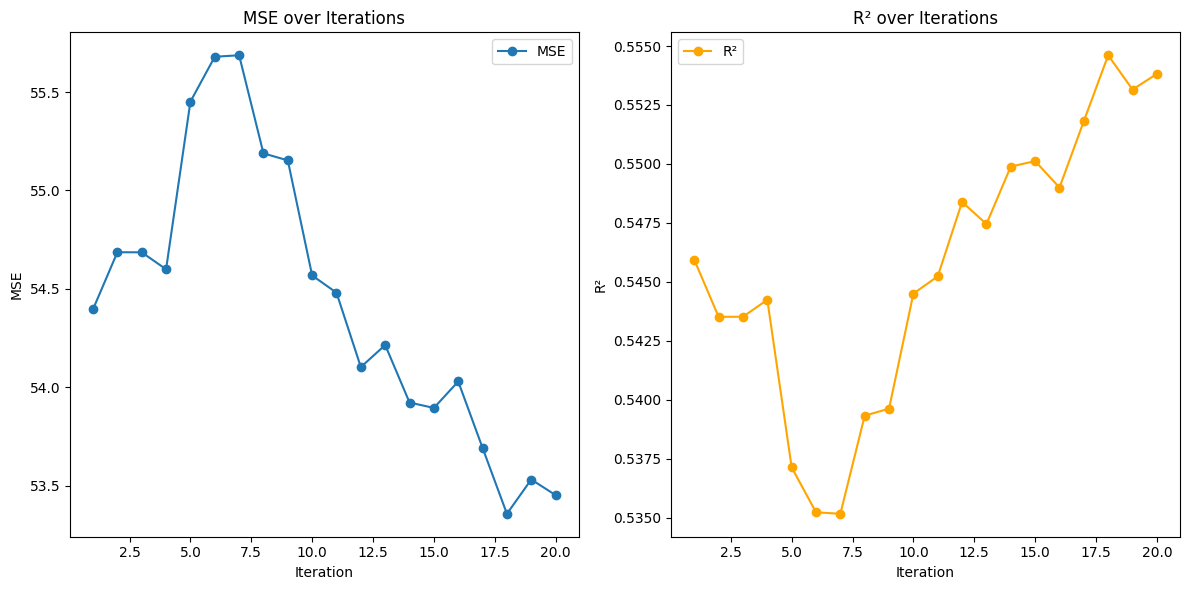

In [ ]:

class EGAL:
    def __init__(self, similarity_threshold=0.5, density_threshold=0.1, model='linear'):
        self.similarity_threshold = similarity_threshold
        self.density_threshold = density_threshold
        self.scaler = StandardScaler()
        self.model_type = model

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.X_scaled = self.scaler.fit_transform(X)
        self.similarity_matrix = euclidean_distances(self.X_scaled)
        self.n = self.similarity_matrix.shape[0]
        self.non_diagonal_elements = np.ravel(self.similarity_matrix[np.triu_indices(self.n, k=1)])
        self.mean_sim = np.mean(self.non_diagonal_elements)
        self.std_sim = np.std(self.non_diagonal_elements)
        self.alpha = self.mean_sim - 0.5 * self.std_sim

    def measure_density(self, idx):
        neighbors = self.similarity_matrix[idx]
        selected_neighbors = neighbors[neighbors < self.alpha]
        density = np.sum(selected_neighbors)
        return density

    def measure_diversity(self, idx, labeled_indices):
        if not labeled_indices:
            return 1
        distances = self.similarity_matrix[idx][labeled_indices]
        return 1 / np.min(distances)

    def select_examples(self, labeled_indices, num_examples=5):
        unlabeled_indices = [i for i in range(len(self.X)) if i not in labeled_indices]
        candidate_set = [idx for idx in unlabeled_indices if self.measure_diversity(idx, labeled_indices) > self.density_threshold]
        densities = [(idx, self.measure_density(idx)) for idx in candidate_set]
        densities.sort(key=lambda x: x[1], reverse=True)
        return [idx for idx, _ in densities[:num_examples]]

    def train_model(self, X, y):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'gbdt':
            model = GradientBoostingRegressor()
        elif self.model_type == 'rf':
            model = RandomForestRegressor()
        elif self.model_type == 'svm':
            model = SVR(kernel='rbf')
        else:
            raise ValueError("Model type not supported.")
        model.fit(X, y)
        return model

    def evaluate_model(self, labeled_indices, X_test, y_test):
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model = self.train_model(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)
            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')

        return labeled_indices, mse_list, r2_list



egal = EGAL(model='linear')
egal.fit(X_train, y_train)

# Perform active learning for 10 iterations
labeled_indices, mse_list_egal, r2_list_egal = egal.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=20, examples_per_iteration=20)


plot_metrics(mse_list_egal, r2_list_egal)


https://ieeexplore.ieee.org/document/6729489
research paper for Expected Model Change Maximization

Iteration 1: Total labeled indices: 520, MSE=54.0648, R2=0.5487
Iteration 2: Total labeled indices: 540, MSE=54.7754, R2=0.5428
Iteration 3: Total labeled indices: 560, MSE=52.8947, R2=0.5585
Iteration 4: Total labeled indices: 580, MSE=51.7424, R2=0.5681
Iteration 5: Total labeled indices: 600, MSE=51.7175, R2=0.5683
Iteration 6: Total labeled indices: 620, MSE=49.6451, R2=0.5856
Iteration 7: Total labeled indices: 640, MSE=48.5641, R2=0.5946
Iteration 8: Total labeled indices: 660, MSE=48.2987, R2=0.5968
Iteration 9: Total labeled indices: 680, MSE=49.8909, R2=0.5835
Iteration 10: Total labeled indices: 700, MSE=49.1573, R2=0.5897
Iteration 11: Total labeled indices: 720, MSE=49.7328, R2=0.5849
Iteration 12: Total labeled indices: 740, MSE=50.2143, R2=0.5808
Iteration 13: Total labeled indices: 760, MSE=49.6864, R2=0.5852
Iteration 14: Total labeled indices: 780, MSE=49.3860, R2=0.5878
Iteration 15: Total labeled indices: 800, MSE=48.6183, R2=0.5942
Iteration 16: Total labeled indice

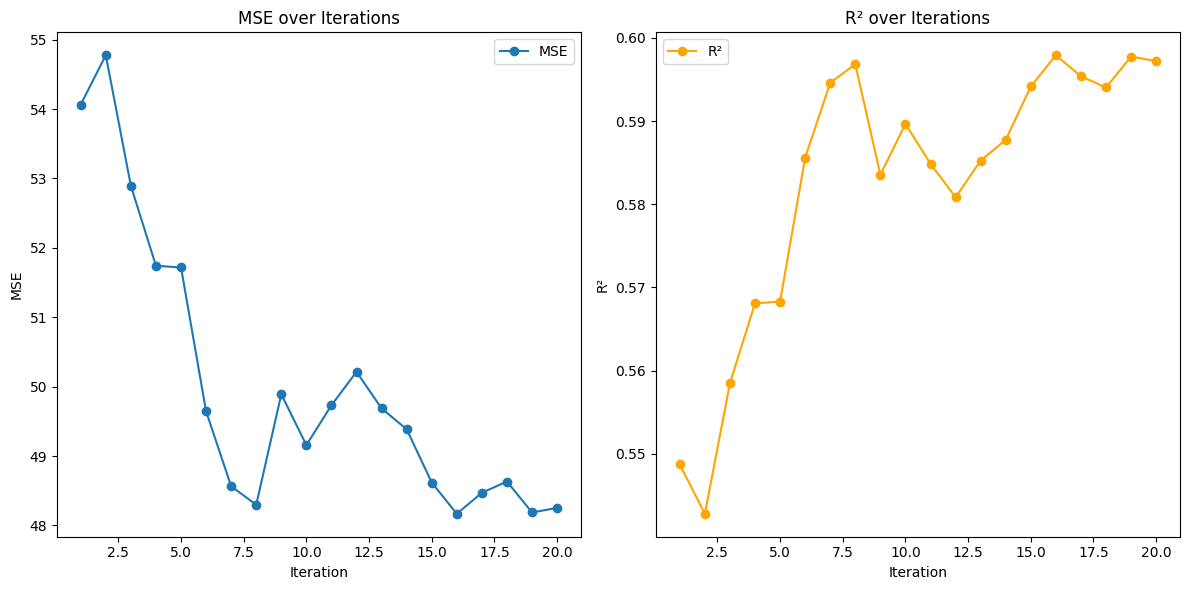

In [ ]:


class EMCM:
    def __init__(self, X, y, model='linear', ensemble_size=10):
        self.X = X
        self.y = y
        self.model_type = model
        self.ensemble_size = ensemble_size
        self.ensemble = []

    def train_model(self, X, y):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'gbdt':
            model = GradientBoostingRegressor()
        elif self.model_type == 'rf':
            model = RandomForestRegressor()
        elif self.model_type == 'svm':
            model = SVR(kernel='rbf')
        else:
            raise ValueError("Model type not supported.")
        model.fit(X, y)
        return model

    def construct_ensemble(self, labeled_indices):
        self.ensemble = []
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        for _ in range(self.ensemble_size):
            X_bootstrap, y_bootstrap = resample(X_labeled, y_labeled)
            model = self.train_model(X_bootstrap, y_bootstrap)
            self.ensemble.append(model)

    def expected_model_change(self, x):
        changes = []
        for model in self.ensemble:
            y_pred = model.predict([x])[0]
            gradient = y_pred - np.mean([model.predict([x])[0] for model in self.ensemble])
            changes.append(np.linalg.norm(gradient * x))
        return np.mean(changes)

    def select_examples(self, labeled_indices, k):
        unlabeled_indices = list(set(range(len(self.X))) - set(labeled_indices))
        expected_changes = []
        for idx in unlabeled_indices:
            change = self.expected_model_change(self.X[idx])
            expected_changes.append((change, idx))
        expected_changes.sort(reverse=True, key=lambda x: x[0])
        return [idx for _, idx in expected_changes[:k]]

    def evaluate_model(self, labeled_indices, X_test, y_test):
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model = self.train_model(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            self.construct_ensemble(labeled_indices)
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)

            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')

        return labeled_indices, mse_list, r2_list

# Example usage:
# Assuming X and y are your full dataset, and you have separate X_test and y_test for evaluation



emcm = EMCM(X_train, y_train, model='linear')  # Use GradientBoostingRegressor
labeled_indices, mse_list_emcm, r2_list_emcm = emcm.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=20, examples_per_iteration=20)
plot_metrics(mse_list_emcm, r2_list_emcm)


https://dl.ifip.org/db/conf/ideal/ideal2007/BurbidgeRK07.pdf
research paper for Query-by-Committee

Iteration 1: Total labeled indices: 520, MSE=53.8427, R2=0.5506
Iteration 2: Total labeled indices: 540, MSE=53.9290, R2=0.5498
Iteration 3: Total labeled indices: 560, MSE=54.1742, R2=0.5478
Iteration 4: Total labeled indices: 580, MSE=53.2886, R2=0.5552
Iteration 5: Total labeled indices: 600, MSE=52.3840, R2=0.5627
Iteration 6: Total labeled indices: 620, MSE=52.3330, R2=0.5632
Iteration 7: Total labeled indices: 640, MSE=52.2351, R2=0.5640
Iteration 8: Total labeled indices: 660, MSE=51.3262, R2=0.5716
Iteration 9: Total labeled indices: 680, MSE=51.3579, R2=0.5713
Iteration 10: Total labeled indices: 700, MSE=51.3867, R2=0.5711
Iteration 11: Total labeled indices: 720, MSE=51.0087, R2=0.5742
Iteration 12: Total labeled indices: 740, MSE=50.9681, R2=0.5745
Iteration 13: Total labeled indices: 760, MSE=51.0367, R2=0.5740
Iteration 14: Total labeled indices: 780, MSE=51.1568, R2=0.5730
Iteration 15: Total labeled indices: 800, MSE=50.1255, R2=0.5816
Iteration 16: Total labeled indice

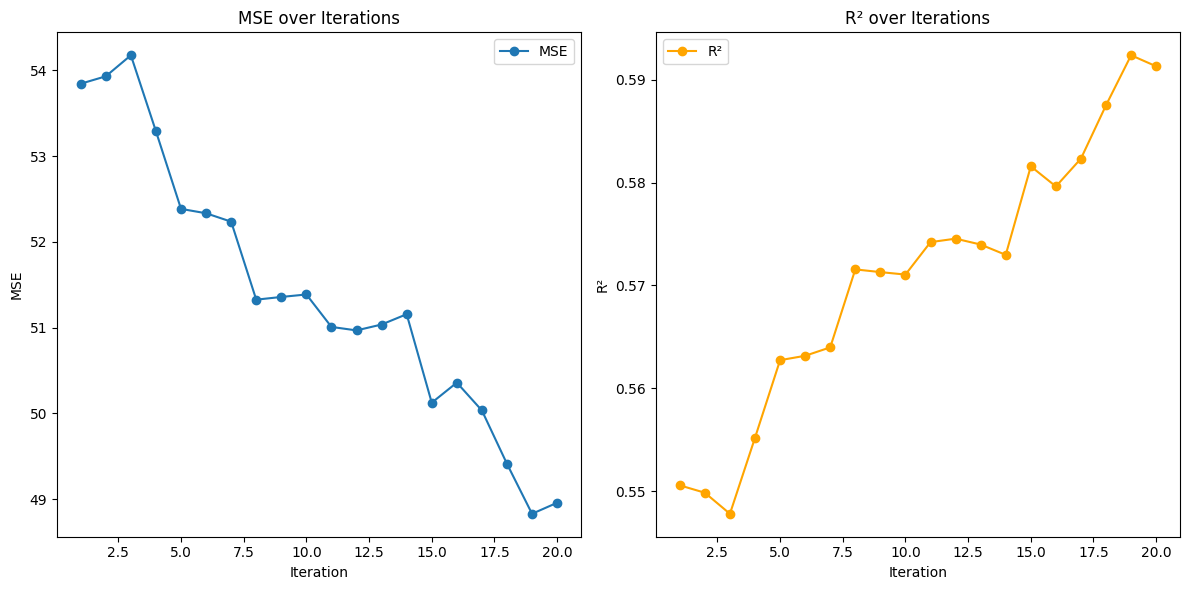

In [ ]:


class QBC:
    def __init__(self, X, y, n_committee=5, model='gbdt'):
        self.X = X
        self.y = y
        self.n_committee = n_committee
        self.models = [self._create_model(model) for _ in range(n_committee)]

    def _create_model(self, model):
        if model == 'rf':
            return RandomForestRegressor()
        elif model == 'gbdt':
            return GradientBoostingRegressor()
        elif model == 'linear':
            return LinearRegression()
        else:
            raise ValueError("Model type not supported")

    def train_committee(self, labeled_indices):
        for model in self.models:
            subset_indices = np.random.choice(labeled_indices, size=len(labeled_indices), replace=True)
            X_subset = self.X[subset_indices]
            y_subset = self.y[subset_indices]
            model.fit(X_subset, y_subset)

    def committee_disagreement(self, x):
        predictions = np.array([model.predict(x.reshape(1, -1))[0] for model in self.models])
        return np.var(predictions)

    def select_examples(self, labeled_indices, num_examples):
        unlabeled_indices = [i for i in range(len(self.X)) if i not in labeled_indices]
        disagreements = [self.committee_disagreement(self.X[i]) for i in unlabeled_indices]
        selected_indices = np.argsort(disagreements)[-num_examples:]
        return [unlabeled_indices[i] for i in selected_indices]

    def evaluate_model(self, labeled_indices, X_test, y_test):
        model = self._create_model('linear')  # Use a new RandomForestRegressor for evaluation
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model.fit(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            self.train_committee(labeled_indices)
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)
            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')
        return labeled_indices, mse_list, r2_list




qbc = QBC(X_train, y_train, model='linear')  # Use LinearRegression for QBC
labeled_indices, mse_list_qbc, r2_list_qbc = qbc.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=20, examples_per_iteration=20)


plot_metrics(mse_list_qbc, r2_list_qbc)


https://arxiv.org/pdf/1808.04245
Research paper for Greedy Sampling- all 3 types

Iteration 1: Total labeled indices: 520, MSE=50.7917, R2=0.5760
Iteration 2: Total labeled indices: 540, MSE=50.9315, R2=0.5749
Iteration 3: Total labeled indices: 560, MSE=49.9459, R2=0.5831
Iteration 4: Total labeled indices: 580, MSE=50.6589, R2=0.5771
Iteration 5: Total labeled indices: 600, MSE=50.9915, R2=0.5744
Iteration 6: Total labeled indices: 620, MSE=49.0809, R2=0.5903
Iteration 7: Total labeled indices: 640, MSE=48.9200, R2=0.5916
Iteration 8: Total labeled indices: 660, MSE=49.3030, R2=0.5884
Iteration 9: Total labeled indices: 680, MSE=48.8239, R2=0.5924
Iteration 10: Total labeled indices: 700, MSE=48.2670, R2=0.5971
Iteration 11: Total labeled indices: 720, MSE=48.2973, R2=0.5968
Iteration 12: Total labeled indices: 740, MSE=47.9693, R2=0.5996
Iteration 13: Total labeled indices: 760, MSE=48.1180, R2=0.5983
Iteration 14: Total labeled indices: 780, MSE=47.1430, R2=0.6065
Iteration 15: Total labeled indices: 800, MSE=46.9421, R2=0.6082
Iteration 16: Total labeled indice

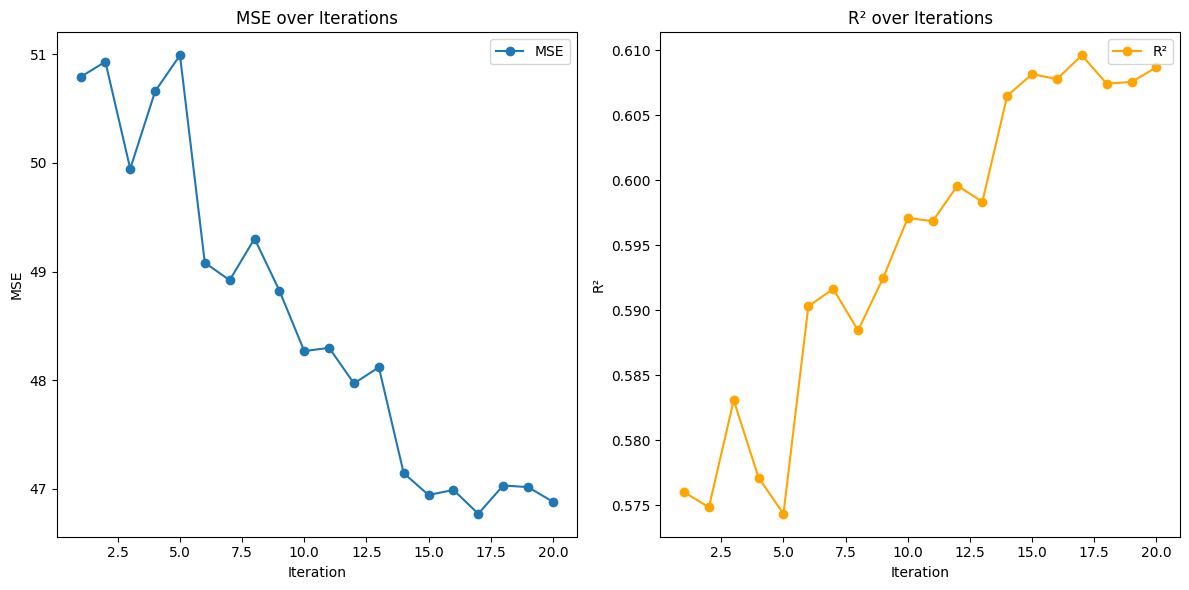

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class GreedySampling:
    def __init__(self, X, y, model='linear'):
        self.X = X
        self.y = y
        self.model_type = model
        self.model = self._create_model(model)

    def _create_model(self, model):
        if model == 'linear':
            return LinearRegression()
        elif model == 'rf':
            return RandomForestRegressor()
        elif model == 'gbdt':
            return GradientBoostingRegressor()
        else:
            raise ValueError("Model type not supported")

    def distance_to_centroid(self, X):
        centroid = np.mean(X, axis=0)
        distances = np.linalg.norm(X - centroid, axis=1)
        return np.argmin(distances)

    def distance_to_labeled(self, X_labeled, X_unlabeled):
        distances = np.min([np.linalg.norm(X_unlabeled - x, axis=1) for x in X_labeled], axis=0)
        return distances



    def select_next_sample_gsx(self, X_labeled, X_unlabeled):
        distances = self.distance_to_labeled(X_labeled, X_unlabeled)
        return np.argmax(distances)

    def select_next_sample_gsy(self, X_labeled, y_labeled, X_unlabeled):
        self.model.fit(X_labeled, y_labeled)
        y_pred_unlabeled = self.model.predict(X_unlabeled)
        distances = np.min([np.abs(y_pred_unlabeled - y) for y in y_labeled], axis=0)
        return np.argmax(distances)

    def select_next_sample_igs(self, X_labeled, y_labeled, X_unlabeled):
        distances_x = self.distance_to_labeled(X_labeled, X_unlabeled)
        self.model.fit(X_labeled, y_labeled)
        y_pred_unlabeled = self.model.predict(X_unlabeled)
        distances_y = np.min([np.abs(y_pred_unlabeled - y) for y in y_labeled], axis=0)
        combined_distances = distances_x * distances_y
        return np.argmax(combined_distances)

    def greedy_sampling(self, initial_indices, X_test, y_test, num_iterations=20, examples_per_iteration=20, strategy='igs'):
        X_labeled = self.X[initial_indices]
        y_labeled = self.y[initial_indices]
        unlabeled_indices = np.setdiff1d(np.arange(len(self.X)), initial_indices)

        mse_scores = []
        r2_scores = []

        for i in range(num_iterations):
            new_indices = []
            for _ in range(examples_per_iteration):
                X_unlabeled = self.X[unlabeled_indices]
                if strategy == 'gsx':
                    next_sample_index = self.select_next_sample_gsx(X_labeled, X_unlabeled)
                elif strategy == 'gsy':
                    next_sample_index = self.select_next_sample_gsy(X_labeled, y_labeled, X_unlabeled)
                elif strategy == 'igs':
                    next_sample_index = self.select_next_sample_igs(X_labeled, y_labeled, X_unlabeled)
                else:
                    raise ValueError("Invalid strategy. Choose from 'gsx', 'gsy', 'igs'.")

                selected_index = unlabeled_indices[next_sample_index]
                new_indices.append(selected_index)
                X_labeled = np.vstack([X_labeled, self.X[selected_index]])
                y_labeled = np.append(y_labeled, self.y[selected_index])
                unlabeled_indices = np.delete(unlabeled_indices, next_sample_index)

            self.model.fit(X_labeled, y_labeled)
            y_pred = self.model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse_scores.append(mse)
            r2_scores.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(X_labeled)}, MSE={mse:.4f}, R2={r2:.4f}')

        return X_labeled, y_labeled, mse_scores, r2_scores




gs = GreedySampling(X_train, y_train, model='linear')  # Use LinearRegression for GreedySampling
X_labeled, y_labeled, mse_list_gs, r2_list_gs = gs.greedy_sampling(initial_labeled_indices, X_test, y_test, num_iterations=20, strategy='igs')

plot_metrics(mse_list_gs, r2_list_gs)


Iteration 1: Total labeled indices: 520, MSE=52.1393, R2=0.5648
Iteration 2: Total labeled indices: 540, MSE=50.4729, R2=0.5787
Iteration 3: Total labeled indices: 560, MSE=49.5037, R2=0.5868
Iteration 4: Total labeled indices: 580, MSE=48.7404, R2=0.5931
Iteration 5: Total labeled indices: 600, MSE=48.7483, R2=0.5931
Iteration 6: Total labeled indices: 620, MSE=48.0702, R2=0.5987
Iteration 7: Total labeled indices: 640, MSE=47.8173, R2=0.6009
Iteration 8: Total labeled indices: 660, MSE=47.4270, R2=0.6041
Iteration 9: Total labeled indices: 680, MSE=46.8407, R2=0.6090
Iteration 10: Total labeled indices: 700, MSE=46.2789, R2=0.6137
Iteration 11: Total labeled indices: 720, MSE=45.8727, R2=0.6171
Iteration 12: Total labeled indices: 740, MSE=46.8869, R2=0.6086
Iteration 13: Total labeled indices: 760, MSE=46.7110, R2=0.6101
Iteration 14: Total labeled indices: 780, MSE=46.8062, R2=0.6093
Iteration 15: Total labeled indices: 800, MSE=45.9411, R2=0.6165
Iteration 16: Total labeled indice

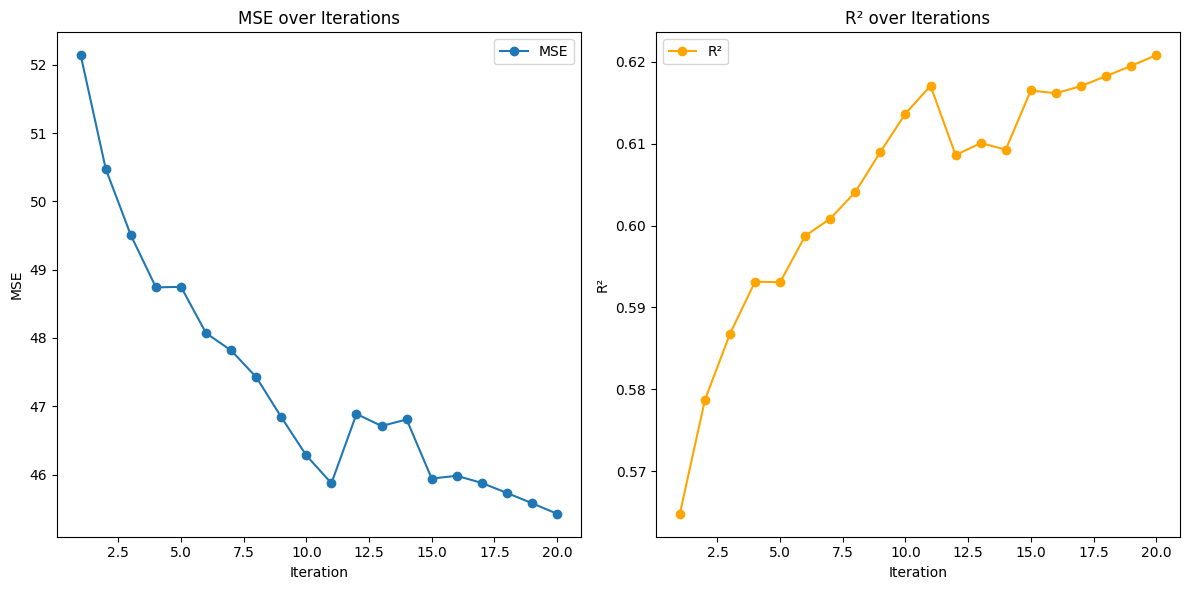

In [ ]:
gs = GreedySampling(X_train, y_train, model='linear')  # Use LinearRegression for GreedySampling
X_labeled, y_labeled, mse_list_gsx, r2_list_gsx = gs.greedy_sampling(initial_labeled_indices, X_test, y_test, num_iterations=20, strategy='gsx')

plot_metrics(mse_list_gsx, r2_list_gsx)

Iteration 1: Total labeled indices: 520, MSE=51.2492, R2=0.5722
Iteration 2: Total labeled indices: 540, MSE=50.4031, R2=0.5793
Iteration 3: Total labeled indices: 560, MSE=50.4534, R2=0.5788
Iteration 4: Total labeled indices: 580, MSE=49.3618, R2=0.5880
Iteration 5: Total labeled indices: 600, MSE=49.0615, R2=0.5905
Iteration 6: Total labeled indices: 620, MSE=49.0716, R2=0.5904
Iteration 7: Total labeled indices: 640, MSE=49.1535, R2=0.5897
Iteration 8: Total labeled indices: 660, MSE=48.4358, R2=0.5957
Iteration 9: Total labeled indices: 680, MSE=48.5726, R2=0.5945
Iteration 10: Total labeled indices: 700, MSE=48.7811, R2=0.5928
Iteration 11: Total labeled indices: 720, MSE=48.7412, R2=0.5931
Iteration 12: Total labeled indices: 740, MSE=48.7713, R2=0.5929
Iteration 13: Total labeled indices: 760, MSE=48.6880, R2=0.5936
Iteration 14: Total labeled indices: 780, MSE=49.0016, R2=0.5910
Iteration 15: Total labeled indices: 800, MSE=48.9990, R2=0.5910
Iteration 16: Total labeled indice

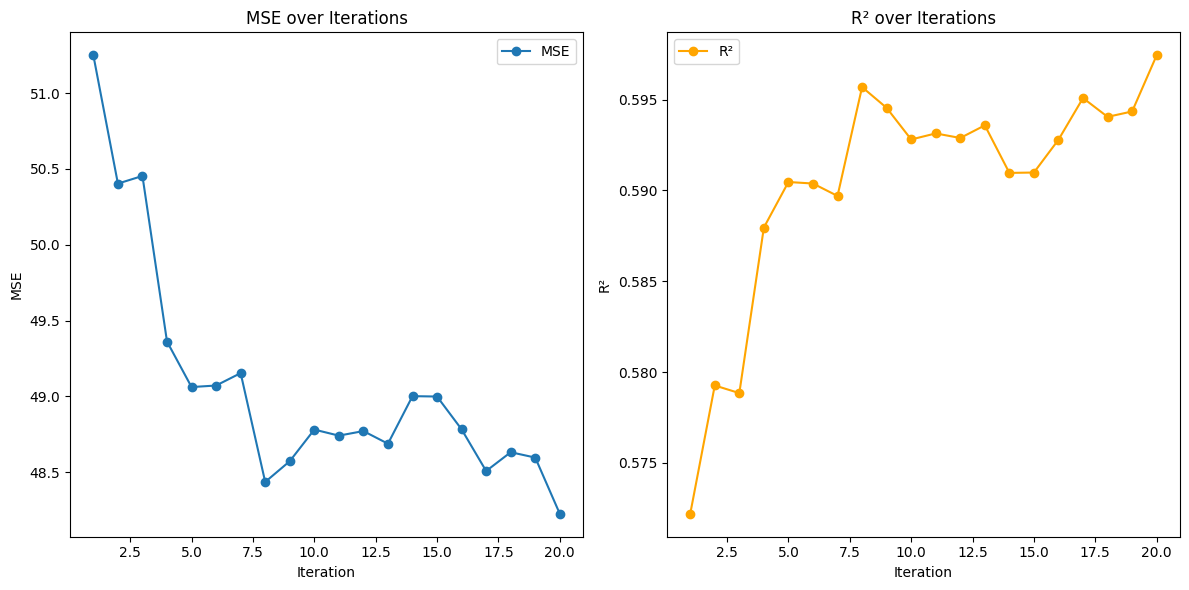

In [ ]:
gs = GreedySampling(X_train, y_train, model='linear')  # Use LinearRegression for GreedySampling
X_labeled, y_labeled, mse_list_gsy, r2_list_gsy = gs.greedy_sampling(initial_labeled_indices, X_test, y_test, num_iterations=20, strategy='gsy')

plot_metrics(mse_list_gsy, r2_list_gsy)

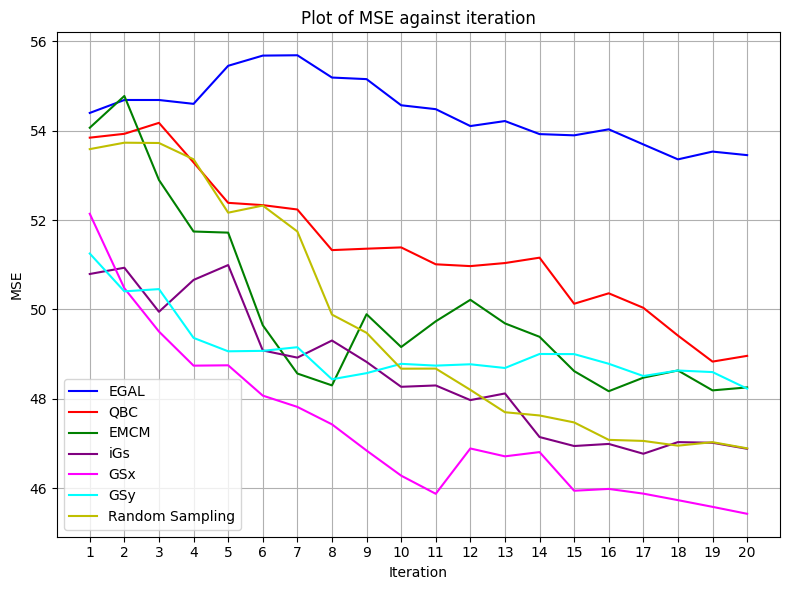

In [ ]:
indices = range(1, len(mse_list_gs) + 1)

# Plot each list against the indices
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.plot(indices, mse_list_egal, linestyle='-', color='b', label='EGAL')
plt.plot(indices, mse_list_qbc, linestyle='-', color='r', label='QBC')
plt.plot(indices, mse_list_emcm, linestyle='-', color='g', label='EMCM')
plt.plot(indices, mse_list_gs, linestyle='-', color='purple', label='iGs')
plt.plot(indices, mse_list_gsx, linestyle='-', color='magenta', label='GSx')
plt.plot(indices, mse_list_gsy, linestyle='-', color='cyan', label='GSy')
plt.plot(indices, mse_list_rs, linestyle='-', color='y', label='Random Sampling')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Plot of MSE against iteration')
plt.xticks(indices)  # Set x-axis ticks to match indices
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


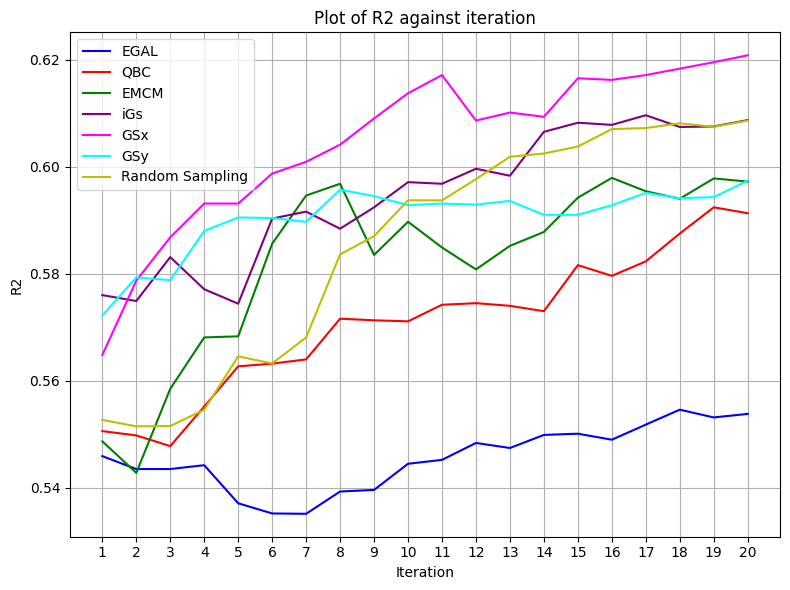

In [ ]:
indices = range(1, len(r2_list_gs) + 1)

# Plot each list against the indices
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.plot(indices, r2_list_egal, linestyle='-', color='b', label='EGAL')
plt.plot(indices, r2_list_qbc, linestyle='-', color='r', label='QBC')
plt.plot(indices, r2_list_emcm, linestyle='-', color='g', label='EMCM')
plt.plot(indices, r2_list_gs, linestyle='-', color='purple', label='iGs')
plt.plot(indices, r2_list_gsx, linestyle='-', color='magenta', label='GSx')
plt.plot(indices, r2_list_gsy, linestyle='-', color='cyan', label='GSy')
plt.plot(indices, r2_list_rs, linestyle='-', color='y', label='Random Sampling')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('R2')
plt.title('Plot of R2 against iteration')
plt.xticks(indices)  # Set x-axis ticks to match indices
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
